<a href="https://colab.research.google.com/github/xslittlemaggie/Deep-Learning-Projects/blob/master/Pixel_level_object(car)_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 0: Import libraries & install package

In [1]:
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, UpSampling2D
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.utils import to_categorical

# graphs
% matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import random
import cv2
import os
import glob

Using TensorFlow backend.


In [2]:
!pip install keras-segmentation

  Created wheel for keras-segmentation: filename=keras_segmentation-0.2.0-cp36-none-any.whl size=25694 sha256=1065f6c771ee1ca1bec2cb7ef5e18ece5b3938139ab6d79c632751bd50dbae1c
  Stored in directory: /root/.cache/pip/wheels/10/43/34/8d5a4aaa8d4479380c3aef57abf90ac47aa1e062c772defa39
Successfully built keras-segmentation


## Step 1: Load data from google drive

### 1. Import drive

In [3]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### 2. Copy data from google drive to colab

In [0]:
# Copy data from google drive to Colab
!cp -r "/content/drive/My Drive/Deep Learning projects/Segmentation_zip/training_data_part.zip" "/content"
!cp -r "/content/drive/My Drive/Deep Learning projects/Segmentation_zip/_out_test_crop_800_256.zip" "/content"
!cp -r "/content/drive/My Drive/Deep Learning projects/Segmentation_zip/_out_crop_800_256.zip" "/content"

### 3. Unzip files

In [13]:
!unzip -q /content/_out_test_crop_800_256.zip -d /content/_out_test_crop_800_256/
!unzip -q /content/_out_crop_800_256.zip -d /content/_out_crop_800_256/
!unzip -q /content/training_data_part.zip -d /content/training_data/

warning [/content/_out_crop_800_256.zip]:  4294967296 extra bytes at beginning or within zipfile
  (attempting to process anyway)
file #1:  bad zipfile offset (local header sig):  4294967296
  (attempting to re-compensate)
file #28084:  bad zipfile offset (local header sig):  289627
  (attempting to re-compensate)


## Step 2: Get familiar with the data & visualize the images

### 1. Visualize one image with the corresponding mask

The original image


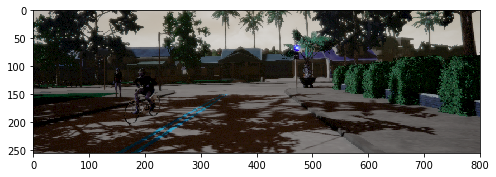

The ground truth


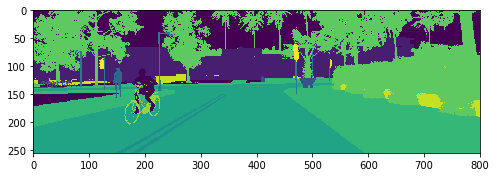

In [7]:
#fig = plt.figure(figsize = (8, 6))
img_RGB = "/content/_out_test_crop_800_256/_out_test_crop_800_256/episode_0000/CameraRGB/000030.png"
img_Seg = "/content/_out_test_crop_800_256/_out_test_crop_800_256/episode_0000/CameraSeg/000030.png"
img_RGB_array = cv2.imread(img_RGB)
img_Seg_array = cv2.imread(img_Seg)
plt.rcParams['figure.figsize'] = (8, 8)
plt.imshow(img_RGB_array)
print("The original image")
plt.show()
plt.imshow(img_Seg_array[:, :, 0])
print("The ground truth")
plt.show()

## Step 3: Create training, testing, validation files to store images, masks respectively

#### Create the global file segmentation and the sub files
 - segmentation/train_dataset
    - imgs
    - labels
    
 - segmentation/test_dataset
    - imgs
    - labels
    
 - segmentation/val_dataset
    - imgs
    - labels



In [0]:
os.mkdir('/content/segmentation/')
os.mkdir('/content/segmentation/train_dataset/')
os.mkdir('/content/segmentation/train_dataset/imgs/')
os.mkdir('/content/segmentation/train_dataset/labels/')

os.mkdir('/content/segmentation/test_dataset/')
os.mkdir('/content/segmentation/test_dataset/imgs/')
os.mkdir('/content/segmentation/test_dataset/labels/')

os.mkdir('/content/segmentation/val_dataset/')
os.mkdir('/content/segmentation/val_dataset/imgs/')
os.mkdir('/content/segmentation/val_dataset/labels/')

## Step 4: Data Preprocessing

#### 1. Move all RGB images, and Seg masks to training dataset

In [0]:
# move all RGB images from 800_256_to train_imgs
# organize training data
episodes = [i[-4:] + "/" for i in glob.glob("/content/_out_crop_800_256/_out_crop_800_256/*")]
for episode in episodes:
  pathes = glob.glob("/content/_out_crop_800_256/_out_crop_800_256/episode_" + episode + "CameraRGB/*.png")
  for path in pathes:
    img_array = cv2.imread(path)
    #try:
    #  img_array/255
    #except:
    #  print(path)
    #  break
    head, tail = os.path.split(path)
    new_path = "/content/segmentation/train_dataset/imgs/" + head[-22:-10] + "_" + tail
    os.rename(path, new_path)
    
# move all RGB images from 800_256_to train_imgs
for episode in episodes:
  pathes = glob.glob("/content/_out_crop_800_256/_out_crop_800_256/episode_" + episode + "CameraSeg/*.png")
  for path in pathes:
    img_array = cv2.imread(path)
    #try:
    #  img_array/255
    #except:
    #  print(path)
    #  break
    head, tail = os.path.split(path)
    new_path = "/content/segmentation/train_dataset/labels/" + head[-22:-10] + "_" + tail
    os.rename(path, new_path)

#### 2. Move all RGB images, and Seg masks to testing dataset

In [0]:
episodes = [i[-4:] + "/" for i in glob.glob("/content/_out_test_crop_800_256/_out_test_crop_800_256/*")]
for episode in episodes:
  pathes = glob.glob("/content/_out_test_crop_800_256/_out_test_crop_800_256/episode_" + episode + "CameraRGB/*.png")
  for path in pathes:    
    img_array = cv2.imread(path)
    head, tail = os.path.split(path)   
    new_path = "/content/segmentation/test_dataset/imgs/" + head[-22:-10] + "_" + tail
    os.rename(path, new_path)
    
for episode in episodes:
  pathes = glob.glob("/content/_out_test_crop_800_256/_out_test_crop_800_256/episode_" + episode + "CameraSeg/*.png")
  for path in pathes:
    img_array = cv2.imread(path)
    head, tail = os.path.split(path)
    new_path = "/content/segmentation/test_dataset/labels/" + head[-22:-10] + "_" + tail
    os.rename(path, new_path)

#### 3. Move all RGB images, and Seg masks to validation dataset

In [0]:
episodes = [i[-4:] + "/" for i in glob.glob("/content/training_data/training_data_part/*")]
for episode in episodes:
  pathes = glob.glob("/content/training_data/training_data_part/episode_" + episode + "CameraRGB/*.png")
  for path in pathes:    
    img_array = cv2.imread(path)
    head, tail = os.path.split(path)   
    new_path = "/content/segmentation/val_dataset/imgs/" + head[-22:-10] + "_" + tail
    os.rename(path, new_path)
    
for episode in episodes:
  pathes = glob.glob("/content/training_data/training_data_part/episode_" + episode + "CameraSeg/*.png")
  for path in pathes:
    img_array = cv2.imread(path)
    head, tail = os.path.split(path)
    new_path = "/content/segmentation/val_dataset/labels/" + head[-22:-10] + "_" + tail
    os.rename(path, new_path)

#### 4. About the final training data

In [17]:
dir_train_images = '/content/segmentation/train_dataset/imgs'
dir_train_labels = '/content/segmentation/train_dataset/labels'

dir_train_images_fname = os.listdir(dir_train_images)
dir_train_labels_fname = os.listdir(dir_train_labels)

print("Total training images:", len(dir_train_images_fname))
print("Total training masks:", len(dir_train_labels_fname))

Total training images: 14400
Total training masks: 14400


#### 5. About the final testing data

In [24]:
dir_test_images = '/content/segmentation/test_dataset/imgs'
dir_test_labels = '/content/segmentation/test_dataset/labels'

dir_test_images_fname = os.listdir(dir_test_images)
dir_test_labels_fname = os.listdir(dir_test_labels)

print("Total testing images:", len(dir_test_images_fname))
print("Total testing masks:", len(dir_test_labels_fname))

Total testing images: 2400
Total testing masks: 2400


#### 6. About the final validation data

In [25]:
dir_val_images = '/content/segmentation/val_dataset/imgs'
dir_val_labels = '/content/segmentation/val_dataset/labels'

dir_val_images_fname = os.listdir(dir_val_images)
dir_val_labels_fname = os.listdir(dir_val_labels)

print("Total validation images:", len(dir_val_images_fname))
print("Total validation masks:", len(dir_val_labels_fname))

Total validation images: 2700
Total validation masks: 2700


## Step 5: Model building

In [20]:
import keras_segmentation
model = keras_segmentation.models.unet.unet(n_classes=13 ,  input_height=256, input_width=800  )

## Step 6: Training

In [21]:
model.train( 
    train_images =  "/content/segmentation/train_dataset/imgs/",
    train_annotations = "/content/segmentation/train_dataset/labels/",
    checkpoints_path = "/content/drive/My Drive/Deep Learning projects/Segmentation_zip/vgg_unet_1" , epochs=30
)

  0%|          | 0/14400 [00:00<?, ?it/s]

Verifying train dataset


100%|██████████| 14400/14400 [01:57<00:00, 122.97it/s]


Dataset verified! 
Starting Epoch  0
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/1
512/512 [==============================] - 145s 283ms/step - loss: 0.9895 - acc: 0.6918
saved  /content/drive/My Drive/Deep Learning projects/Segmentation_zip/vgg_unet_1.model.0
Finished Epoch 0
Starting Epoch  1
Epoch 1/1
512/512 [==============================] - 138s 270ms/step - loss: 0.6388 - acc: 0.7936
saved  /content/drive/My Drive/Deep Learning projects/Segmentation_zip/vgg_unet_1.model.1
Finished Epoch 1
Starting Epoch  2
Epoch 1/1
512/512 [==============================] - 138s 270ms/step - loss: 0.5508 - acc: 0.8211
saved  /content/drive/My Drive/Deep Learning projects/Segmentation_zip/vgg_unet_1.model.2
Finished Epoch 2
Starting Epoch  3
Epoch 1/1
512/512 [==============================] - 138s 270ms/step - loss: 0.4716 - acc: 0.8475
saved  /content/drive/My Drive/Deep Learning projects/Segmentation_zip/vgg_unet_1.model.3
Finished Epo

## Step 7: Prediction

Image # 1
The origianl image


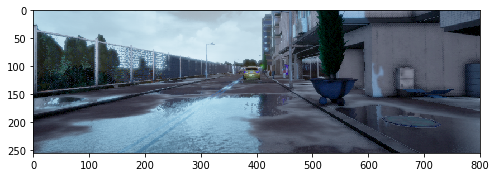

The predicted image


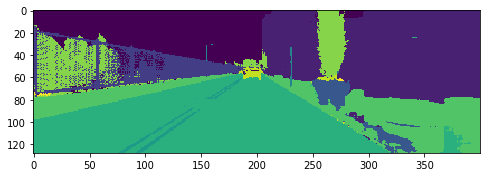

The ground truth


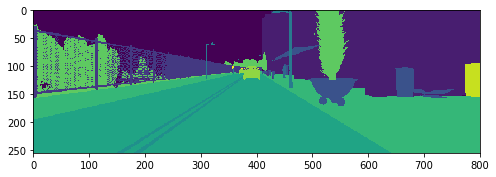

************************************************************
************************************************************
Image # 2
The origianl image


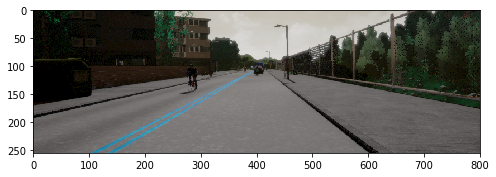

The predicted image


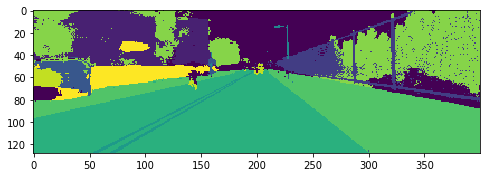

The ground truth


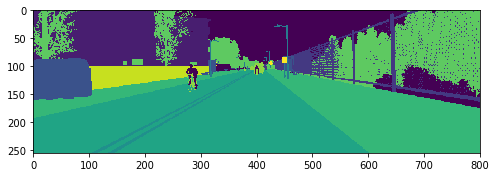

************************************************************
************************************************************


In [23]:
img_pathes = glob.glob("/content/segmentation/train_dataset/imgs/*.png")
mask_pathes = glob.glob("/content/segmentation/train_dataset/labels/*.png")
#img_path = "/content/segmentation/train_dataset/imgs/episode_0005_000034.png"
for i in range(2):
  predicted = model.predict_segmentation(inp=img_pathes[i], out_fname="/tmp/out.png")
  print("Image # {}".format(i + 1))
  print("The origianl image")
  plt.imshow(cv2.imread(img_pathes[i]))
  plt.show()
  print("The predicted image")
  plt.imshow(predicted)
  plt.show()
  print("The ground truth")
  plt.imshow(cv2.imread(mask_pathes[i])[:, :, 0])
  plt.show()
  print("*" * 60)
  print("*" * 60)